# 07-Mask R-CNN and U-NET

Mask R-CNN was originally released under the Caffe2 framework by the FAIR team as part of a project called "Detectron."

After Caffe2 and PyTorch merged, eventually, FAIR released a ground-up reimplementation of Detectron with new models and
features. This framework is [Detectron2](https://github.com/facebookresearch/detectron2). If you're looking for a complete
approach to bounding box regression, mask regression, and skeleton point (pose) estimation, take a look.

In the meantime, however, other groups quickly implemented Mask R-CNN directly in TensorFlow and Keras.
Today we'll analyze the network with a [PyTorch implementation of Mask R-CNN](https://github.com/multimodallearning/pytorch-mask-rcnn), because the code is easier to understand coding architecture. However, the link is old, so we will implement the code running into [PyTorch Simple Mask R-CNN](https://github.com/Okery/PyTorch-Simple-MaskRCNN).

The full of Mask R-CNN structure is below:

<img src="img/MaskRCNNArchitecture.png" title="FullMaskR-CNN" style="width: 860px;" />

For each intance of an object in an image, Mask R-CNN attempts to generate
 - A bounding box
 - A segmentation mask

The backbone and neck of Mask R-CNN are based on
 - A feature pyramid networks (FPN)
 - ResNet 101

## Feature Pyramid Networks

We've seen the feature pyramid network (FPN) in YOLOv3 and YOLOv4. It is a feature extractor using a pyramid concept.
We begin with ordinary progressive downsampling of the input to get a multiscale representation of the input, but rather
than using that "low-level" multiscale representation directly, we progressively upsample the coarse representation of
the input using input from the low-level feature maps. The idea is shown in the left-hand panel of the diagram above.
By incorporating information from both the low-level "bottom-up" fine grained feature map and the upsampled coarser grained feature
map in the pyramid, the fine grained representation at the bottom of the pyramid contain much more useful or more "semantic"
information about the input.

Feature pyramids can, in principle, come in many different forms. Refer to the figure below, which is
from [Towards Data Science](https://towardsdatascience.com/review-fpn-feature-pyramid-network-object-detection-262fc7482610):

<img src="img/Pyramid.png" title="PyramidNets" style="width: 800px;" />

The classical image pyramid, used by many techniques aiming at multiscale detection, looks like (a).
Classifiers we built early on in the class, such as AlexNet, look like (b). (c) and (d) utilize multiple
feature maps derived from the input through progressive downscaling. The difference in the FPN (d) is
the inclusion of both bottom up and top down pathways:

<img src="img/bottomup.jpeg" title="Bottom-up" style="width: 500px;" />

We know that as we process the input in multiple progressively downsampled layers, we are increasingly analyzing higher-level features
with larger receptive fields with some invariance to imaging conditions (translation, scale, lighting, etc.).

The top-down representations use progressively *upsampled* layers in which we are increasingly analyzing the input at high resolution but
with all the benefits of the downsampled representation.

The main risk of the top-down upsampling is that we would lose information about the details of the original input in constructing the
fine-grained feature maps. For that reason, we add lateral connections to the bottom-up feature maps of the same size:

<img src="img/lateralconnection.png" title="lateralconnection" style="width: 500px;" />

## ResNet backbone

The bottom-up part of the FPN used in Mask-RCNN is ResNet. It is used similar to how
Darknet-53 is used in YOLO. We take the classifier structure as the bottom-up half of
the pyramid, then we add the top down part to obtain the FPN.

Mask R-CNN taps into ResNet in 4 or 5 places according to the implementation, at the ouptut of various residual blocks.

Here's a figure to explain this, this time from [Jonathan Hui's Medium site](https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c):

<img src="img/upanddown.png" title="upanddown" style="width: 500px;" />

(There would be a P6 there as well if we're extracting a 5-scale pyramid).

## Region Proposal Network (RPN)

A Region Proposal Network (RPN) is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position.

RPNs are designed to predict region proposals with a wide range of scales and aspect ratios. RPNs use anchor boxes that serve as references at multiple scales and aspect ratios. The scheme can be thought of as a pyramid of regression references, which avoids enumerating images or filters of multiple scales or aspect ratios.

The Faster R-CNN RPN connects to the top of the pyramid. It performs classification and bounding box regression for each possible proposal.

<img src="img/RPN.png" title="RPN" style="width: 600px;" />

## Detection network

The detection network uses the results of the RPN as well as the output of the FPN. With the RPN bounding box as input, we assign the box to one of the levels of the pyramid.
Specifically, we use

$$ k = \left\lfloor k_0 +\log_2\left( \frac{\sqrt{wh}}{224} \right) \right\rfloor $$

Then the ROIAlign block interpolates the appropriate set of features from the best level (level $k$) of the pyramid. The region is aligned and scaled to a size of
56$\times$56, and the resulting representation is forwarded to the mask prediction head.

## Mask Head

The mask head is a FCN that up-samples from the detection result, and the patch size is finally re-scaled back to the input size.

## Coding

So let's start investigating how Mask R-CNN works in detail.
First, open the [Github respository](https://github.com/multimodallearning/pytorch-mask-rcnn.git):

### MaskRCNN class (model.py)

Let's visit the MaskRCNN class and its <code>init()</code> function:

In [ ]:
def __init__(self, config, model_dir):
    """
    config: A Sub-class of the Config class
    model_dir: Directory to save training logs and trained weights
    """
    super(MaskRCNN, self).__init__()
    self.config = config
    self.model_dir = model_dir
    self.set_log_dir()
    self.build(config=config)
    self.initialize_weights()
    self.loss_history = []
    self.val_loss_history = []

The most important action here is calling `build()`, which creates the network based on a
configuration object. `set_log_dir()` just sets up saving to a log file, and `initialize_weights()` loads
weights. Let's take a look at the `build()` function:

In [ ]:
def build(self, config):
    """Build Mask R-CNN architecture.
    """

    # Image size must be dividable by 2 multiple times
    h, w = config.IMAGE_SHAPE[:2]
    if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
        raise Exception("Image size must be dividable by 2 at least 6 times "
                        "to avoid fractions when downscaling and upscaling."
                        "For example, use 256, 320, 384, 448, 512, ... etc. ")

    # Build the shared convolutional layers.
    # Bottom-up Layers
    # Returns a list of the last layers of each stage, 5 in total.
    # Don't create the thead (stage 5), so we pick the 4th item in the list.
    resnet = ResNet("resnet101", stage5=True)
    C1, C2, C3, C4, C5 = resnet.stages()

    # Top-down Layers
    # TODO: add assert to varify feature map sizes match what's in config
    self.fpn = FPN(C1, C2, C3, C4, C5, out_channels=256)

    # Generate Anchors
    self.anchors = Variable(torch.from_numpy(utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                                                            config.RPN_ANCHOR_RATIOS,
                                                                            config.BACKBONE_SHAPES,
                                                                            config.BACKBONE_STRIDES,
                                                                            config.RPN_ANCHOR_STRIDE)).float(), requires_grad=False)
    if self.config.GPU_COUNT:
        self.anchors = self.anchors.cuda()

    # RPN
    self.rpn = RPN(len(config.RPN_ANCHOR_RATIOS), config.RPN_ANCHOR_STRIDE, 256)

    # FPN Classifier
    self.classifier = Classifier(256, config.POOL_SIZE, config.IMAGE_SHAPE, config.NUM_CLASSES)

    # FPN Mask
    self.mask = Mask(256, config.MASK_POOL_SIZE, config.IMAGE_SHAPE, config.NUM_CLASSES)

    # Fix batch norm layers
    def set_bn_fix(m):
        classname = m.__class__.__name__
        if classname.find('BatchNorm') != -1:
            for p in m.parameters(): p.requires_grad = False

    self.apply(set_bn_fix)

### Backbone

The backbone is initialized then tapped into in the lines

    resnet = ResNet("resnet101", stage5=True)
    C1, C2, C3, C4, C5 = resnet.stages()

We see that this version is using ResNet101 and extracting a 5-stages pyramid. How to find out what stages are being used? Take
a look at the ResNet class itself and take a look at its `__init__` and forward methods. We see that the C1-C5 are the main
blocks of the network. The first (C1) is a single 7$\times$7 convolution with batch norm, ReLU, and a MaxPool operation. The others
(C2-C5) are ResNet residual blocks.

In [ ]:
class ResNet(nn.Module):

    def __init__(self, architecture, stage5=False):
        super(ResNet, self).__init__()
        assert architecture in ["resnet50", "resnet101"]
        self.inplanes = 64
        self.layers = [3, 4, {"resnet50": 6, "resnet101": 23}[architecture], 3]
        self.block = Bottleneck
        self.stage5 = stage5

        self.C1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64, eps=0.001, momentum=0.01),
            nn.ReLU(inplace=True),
            SamePad2d(kernel_size=3, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.C2 = self.make_layer(self.block, 64, self.layers[0])
        self.C3 = self.make_layer(self.block, 128, self.layers[1], stride=2)
        self.C4 = self.make_layer(self.block, 256, self.layers[2], stride=2)
        if self.stage5:
            self.C5 = self.make_layer(self.block, 512, self.layers[3], stride=2)
        else:
            self.C5 = None

    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)
        x = self.C3(x)
        x = self.C4(x)
        x = self.C5(x)
        return x

    def stages(self):
        return [self.C1, self.C2, self.C3, self.C4, self.C5]

    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * block.expansion, eps=0.001, momentum=0.01),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

### FPN

Let's go back to the MaskRCNN class. The next stage is FPN (Top-down layers)

    self.fpn = FPN(C1, C2, C3, C4, C5, out_channels=256)

The main idea of the FPN is in its `forward()` method. Let's take a look.

In [ ]:
class FPN(nn.Module):
    def __init__(self, C1, C2, C3, C4, C5, out_channels):
        super(FPN, self).__init__()
        self.out_channels = out_channels
        self.C1 = C1
        self.C2 = C2
        self.C3 = C3
        self.C4 = C4
        self.C5 = C5
        self.P6 = nn.MaxPool2d(kernel_size=1, stride=2)
        self.P5_conv1 = nn.Conv2d(2048, self.out_channels, kernel_size=1, stride=1)
        self.P5_conv2 = nn.Sequential(
            SamePad2d(kernel_size=3, stride=1),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
        )
        self.P4_conv1 =  nn.Conv2d(1024, self.out_channels, kernel_size=1, stride=1)
        self.P4_conv2 = nn.Sequential(
            SamePad2d(kernel_size=3, stride=1),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
        )
        self.P3_conv1 = nn.Conv2d(512, self.out_channels, kernel_size=1, stride=1)
        self.P3_conv2 = nn.Sequential(
            SamePad2d(kernel_size=3, stride=1),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
        )
        self.P2_conv1 = nn.Conv2d(256, self.out_channels, kernel_size=1, stride=1)
        self.P2_conv2 = nn.Sequential(
            SamePad2d(kernel_size=3, stride=1),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
        )

    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)
        c2_out = x          # keep C2 output
        x = self.C3(x)
        c3_out = x          # keep C3 output
        x = self.C4(x)
        c4_out = x          # keep C4 output
        x = self.C5(x)
        p5_out = self.P5_conv1(x)       # top-most of pyramid
        p4_out = self.P4_conv1(c4_out) + F.upsample(p5_out, scale_factor=2)         # lateral connections, 2nd top output
        p3_out = self.P3_conv1(c3_out) + F.upsample(p4_out, scale_factor=2)         # lateral connections, 3rd top output
        p2_out = self.P2_conv1(c2_out) + F.upsample(p3_out, scale_factor=2)         # lateral connections, 4th top output

        p5_out = self.P5_conv2(p5_out)
        p4_out = self.P4_conv2(p4_out)
        p3_out = self.P3_conv2(p3_out)
        p2_out = self.P2_conv2(p2_out)

        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        p6_out = self.P6(p5_out)        # max pooling for RPN

        return [p2_out, p3_out, p4_out, p5_out, p6_out]

### Anchors

Anchor box sizes are set in the configuration file.

### RPN

Next, let's see how the RPN is produced.

    self.rpn = RPN(len(config.RPN_ANCHOR_RATIOS), config.RPN_ANCHOR_STRIDE, 256)

The RPN class is reproduced below. But also take a look at its output. It releases classes (score, and softmax), and bounding boxes.

In [ ]:
class RPN(nn.Module):
    """Builds the model of Region Proposal Network.

    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_logits: [batch, H, W, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, W, W, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H, W, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """

    def __init__(self, anchors_per_location, anchor_stride, depth):
        super(RPN, self).__init__()
        self.anchors_per_location = anchors_per_location
        self.anchor_stride = anchor_stride
        self.depth = depth

        self.padding = SamePad2d(kernel_size=3, stride=self.anchor_stride)
        self.conv_shared = nn.Conv2d(self.depth, 512, kernel_size=3, stride=self.anchor_stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv_class = nn.Conv2d(512, 2 * anchors_per_location, kernel_size=1, stride=1)     # class, score
        self.softmax = nn.Softmax(dim=2)
        self.conv_bbox = nn.Conv2d(512, 4 * anchors_per_location, kernel_size=1, stride=1)      # x,y,w,h

    def forward(self, x):
        # Shared convolutional base of the RPN
        x = self.relu(self.conv_shared(self.padding(x)))

        # Anchor Score. [batch, anchors per location * 2, height, width].
        rpn_class_logits = self.conv_class(x)

        # Reshape to [batch, 2, anchors]
        rpn_class_logits = rpn_class_logits.permute(0,2,3,1)
        rpn_class_logits = rpn_class_logits.contiguous()
        rpn_class_logits = rpn_class_logits.view(x.size()[0], -1, 2)

        # Softmax on last dimension of BG/FG.
        rpn_probs = self.softmax(rpn_class_logits)              # output class

        # Bounding box refinement. [batch, H, W, anchors per location, depth]
        # where depth is [x, y, log(w), log(h)]
        rpn_bbox = self.conv_bbox(x)

        # Reshape to [batch, 4, anchors]
        rpn_bbox = rpn_bbox.permute(0,2,3,1)
        rpn_bbox = rpn_bbox.contiguous()
        rpn_bbox = rpn_bbox.view(x.size()[0], -1, 4)

        return [rpn_class_logits, rpn_probs, rpn_bbox]

### Proposal classifier

The Faster R-CNN head contains the region proposal classifier.

    self.classifier = Classifier(256, config.POOL_SIZE, config.IMAGE_SHAPE, config.NUM_CLASSES)

The classifier is mainly composed of convolutional layers. The most
interesting process is the pyramidal ROI alignment at multiple scales.
At the Classifier class, the combine ROIs aligned is in function pyramid_roi_align.

Let's take a look the `pyramid_roi_align()` method, which contains the cropping and resizing of incoming feature maps according to region proposals.

In [ ]:
def pyramid_roi_align(inputs, pool_size, image_shape):
    """Implements ROI Pooling on multiple levels of the feature pyramid.

    Params:
    - pool_size: [height, width] of the output pooled regions. Usually [7, 7]
    - image_shape: [height, width, channels]. Shape of input image in pixels

    Inputs:
    - boxes: [batch, num_boxes, (y1, x1, y2, x2)] in normalized
             coordinates.
    - Feature maps: List of feature maps from different levels of the pyramid.
                    Each is [batch, channels, height, width]

    Output:
    Pooled regions in the shape: [num_boxes, height, width, channels].
    The width and height are those specific in the pool_shape in the layer
    constructor.
    """

    # Currently only supports batchsize 1
    for i in range(len(inputs)):
        inputs[i] = inputs[i].squeeze(0)

    # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
    boxes = inputs[0]

    # Feature Maps. List of feature maps from different level of the
    # feature pyramid. Each is [batch, height, width, channels]
    feature_maps = inputs[1:]

    # Assign each ROI to a level in the pyramid based on the ROI area.
    y1, x1, y2, x2 = boxes.chunk(4, dim=1)
    h = y2 - y1
    w = x2 - x1

    # Equation 1 in the Feature Pyramid Networks paper. Account for
    # the fact that our coordinates are normalized here.
    # e.g. a 224x224 ROI (in pixels) maps to P4
    image_area = Variable(torch.FloatTensor([float(image_shape[0]*image_shape[1])]), requires_grad=False)
    if boxes.is_cuda:
        image_area = image_area.cuda()
    roi_level = 4 + log2(torch.sqrt(h*w)/(224.0/torch.sqrt(image_area)))
    roi_level = roi_level.round().int()
    roi_level = roi_level.clamp(2,5)


    # Loop through levels and apply ROI pooling to each. P2 to P5.
    pooled = []
    box_to_level = []
    for i, level in enumerate(range(2, 6)):
        ix  = roi_level==level
        if not ix.any():
            continue
        ix = torch.nonzero(ix)[:,0]
        level_boxes = boxes[ix.data, :]

        # Keep track of which box is mapped to which level
        box_to_level.append(ix.data)

        # Stop gradient propogation to ROI proposals
        level_boxes = level_boxes.detach()

        # Crop and Resize
        # From Mask R-CNN paper: "We sample four regular locations, so
        # that we can evaluate either max or average pooling. In fact,
        # interpolating only a single value at each bin center (without
        # pooling) is nearly as effective."
        #
        # Here we use the simplified approach of a single value per bin,
        # which is how it's done in tf.crop_and_resize()
        # Result: [batch * num_boxes, pool_height, pool_width, channels]
        ind = Variable(torch.zeros(level_boxes.size()[0]),requires_grad=False).int()
        if level_boxes.is_cuda:
            ind = ind.cuda()
        feature_maps[i] = feature_maps[i].unsqueeze(0)  #CropAndResizeFunction needs batch dimension
        pooled_features = CropAndResizeFunction(pool_size, pool_size, 0)(feature_maps[i], level_boxes, ind)
        pooled.append(pooled_features)

    # Pack pooled features into one tensor
    pooled = torch.cat(pooled, dim=0)

    # Pack box_to_level mapping into one array and add another
    # column representing the order of pooled boxes
    box_to_level = torch.cat(box_to_level, dim=0)

    # Rearrange pooled features to match the order of the original boxes
    _, box_to_level = torch.sort(box_to_level)
    pooled = pooled[box_to_level, :, :]

    return pooled

### Mask Head

The last step creates the mask head. We have convolutions and upsampling to the original image size.
The difference between the classifier head and the mask head is that the classifier head takes the proposal bounding boxes
and outputs final bounding boxes whereas the mask head uses the final bounding boxes to create masks.

The mask creation in the MaskRCNN class is here:

    self.mask = Mask(256, config.MASK_POOL_SIZE, config.IMAGE_SHAPE, config.NUM_CLASSES)

### Prediction function

Now let's look at the overall
`predict()` method. There are two modes there: inference (evaluate) mode and training mode.
Both modes have the same steps, but during training, we have to calculate ROI sizes for comparisons between the predicted output and the ground truth.

In [ ]:
def predict(self, input, mode):
    molded_images = input[0]
    image_metas = input[1]

    if mode == 'inference':
        self.eval()
    elif mode == 'training':
        self.train()

        # Set batchnorm always in eval mode during training
        def set_bn_eval(m):
            classname = m.__class__.__name__
            if classname.find('BatchNorm') != -1:
                m.eval()

        self.apply(set_bn_eval)

    # Feature extraction
    [p2_out, p3_out, p4_out, p5_out, p6_out] = self.fpn(molded_images)

    # Note that P6 is used in RPN, but not in the classifier heads.
    rpn_feature_maps = [p2_out, p3_out, p4_out, p5_out, p6_out]
    mrcnn_feature_maps = [p2_out, p3_out, p4_out, p5_out]

    # Loop through pyramid layers
    layer_outputs = []  # list of lists
    for p in rpn_feature_maps:
        layer_outputs.append(self.rpn(p))

    # Concatenate layer outputs
    # Convert from list of lists of level outputs to list of lists
    # of outputs across levels.
    # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
    outputs = list(zip(*layer_outputs))
    outputs = [torch.cat(list(o), dim=1) for o in outputs]
    rpn_class_logits, rpn_class, rpn_bbox = outputs

    # Generate proposals
    # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
    # and zero padded.
    proposal_count = self.config.POST_NMS_ROIS_TRAINING if mode == "training" \
        else self.config.POST_NMS_ROIS_INFERENCE
    rpn_rois = proposal_layer([rpn_class, rpn_bbox],
                             proposal_count=proposal_count,
                             nms_threshold=self.config.RPN_NMS_THRESHOLD,
                             anchors=self.anchors,
                             config=self.config)

    if mode == 'inference':
        # Network Heads
        # Proposal classifier and BBox regressor heads
        mrcnn_class_logits, mrcnn_class, mrcnn_bbox = self.classifier(mrcnn_feature_maps, rpn_rois)

        # Detections
        # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in image coordinates
        detections = detection_layer(self.config, rpn_rois, mrcnn_class, mrcnn_bbox, image_metas)

        # Convert boxes to normalized coordinates
        # TODO: let DetectionLayer return normalized coordinates to avoid
        #       unnecessary conversions
        h, w = self.config.IMAGE_SHAPE[:2]
        scale = Variable(torch.from_numpy(np.array([h, w, h, w])).float(), requires_grad=False)
        if self.config.GPU_COUNT:
            scale = scale.cuda()
        detection_boxes = detections[:, :4] / scale

        # Add back batch dimension
        detection_boxes = detection_boxes.unsqueeze(0)

        # Create masks for detections
        mrcnn_mask = self.mask(mrcnn_feature_maps, detection_boxes)

        # Add back batch dimension
        detections = detections.unsqueeze(0)
        mrcnn_mask = mrcnn_mask.unsqueeze(0)

        return [detections, mrcnn_mask]

    elif mode == 'training':

        gt_class_ids = input[2]
        gt_boxes = input[3]
        gt_masks = input[4]

        # Normalize coordinates
        h, w = self.config.IMAGE_SHAPE[:2]
        scale = Variable(torch.from_numpy(np.array([h, w, h, w])).float(), requires_grad=False)
        if self.config.GPU_COUNT:
            scale = scale.cuda()
        gt_boxes = gt_boxes / scale

        # Generate detection targets
        # Subsamples proposals and generates target outputs for training
        # Note that proposal class IDs, gt_boxes, and gt_masks are zero
        # padded. Equally, returned rois and targets are zero padded.
        rois, target_class_ids, target_deltas, target_mask = \
            detection_target_layer(rpn_rois, gt_class_ids, gt_boxes, gt_masks, self.config)

        if not rois.size():
            mrcnn_class_logits = Variable(torch.FloatTensor())
            mrcnn_class = Variable(torch.IntTensor())
            mrcnn_bbox = Variable(torch.FloatTensor())
            mrcnn_mask = Variable(torch.FloatTensor())
            if self.config.GPU_COUNT:
                mrcnn_class_logits = mrcnn_class_logits.cuda()
                mrcnn_class = mrcnn_class.cuda()
                mrcnn_bbox = mrcnn_bbox.cuda()
                mrcnn_mask = mrcnn_mask.cuda()
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox = self.classifier(mrcnn_feature_maps, rois)

            # Create masks for detections
            mrcnn_mask = self.mask(mrcnn_feature_maps, rois)

        return [rpn_class_logits, rpn_bbox, target_class_ids, mrcnn_class_logits, target_deltas, mrcnn_bbox, target_mask, mrcnn_mask]


### Configuration

Check `config.py` to see the possible
configuration templates to change configuration information such as image size and number of classes.
Sample configuration and dataset setup can be seen in coco.py.


## Let's do Mask R-CNN training

OK, let's get it all working.

Clone the github respository:

In [ ]:
!https://github.com/Okery/PyTorch-Simple-MaskRCNN.git

`python train.py --use-cuda --iters -1 --epochs 5 --dataset voc --data-dir /data/VOC2012`

Use "train.py" to train and the code. Try to learn how to use argument passing module `argparse` in `.py` files.

`import argparse`  
`parser = argparse.ArgumentParser()`  
`parser.add_argument("--use-cuda", action="store_true")`  
    
`parser.add_argument("--dataset", default="coco", help="coco or voc")`  
`parser.add_argument("--data-dir", default="E:/PyTorch/data/coco2017")`  
`parser.add_argument("--ckpt-path")`  
`parser.add_argument("--results")`  
    
`parser.add_argument("--seed", type=int, default=3)`  
`parser.add_argument('--lr-steps', nargs="+", type=int, default=[6, 7])`  
`parser.add_argument("--lr", type=float)`  
`parser.add_argument("--momentum", type=float, default=0.9)`  
`parser.add_argument("--weight-decay", type=float, default=0.0001)`  
    
`parser.add_argument("--epochs", type=int, default=3)`  
`parser.add_argument("--iters", type=int, default=10, help="max iters per epoch, -1 denotes auto")`  
`parser.add_argument("--print-freq", type=int, default=100, help="frequency of printing losses")`  
`args = parser.parse_args()`

### Additional: Download coco dataset

COCO dataset directory should be like this:

<code>
coco2017/
    annotations/
        instances_train2017.json
        instances_val2017.json
        ...
    train2017/
        000000000009.jpg
        ...
    val2017/
        000000000139.jpg
        ...
</code>

You can create fifty-one.py to download the dataset
- change the dataset name correctly is better
- when I download the dataset, the data path may not ok for the code, you just change the dataset folder name and everything will be fine.
- City scapes need to download manually and extract by the code.

https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#dataset-zoo-cityscapes

In [ ]:
# fifty-one.py
# !pip install fiftyone

import fiftyone as fo
import fiftyone.zoo as foz

# List available zoo datasets
print(foz.list_zoo_datasets())

#
# Load the COCO-2017 validation split into a FiftyOne dataset
#
# This will download the dataset from the web, if necessary
#
dataset_name = "coco-2017"
# dataset_name = "cityscapes"
dataset = foz.load_zoo_dataset(dataset_name)

# Give the dataset a new name, and make it persistent so that you can
# work with it in future sessions
dataset.name = dataset_name
dataset.persistent = True

# Visualize the in the App
session = fo.launch_app(dataset)

ModuleNotFoundError: No module named 'fiftyone'

In [ ]:
import os
os.environ['http_proxy'] = "http://squid.cs.ait.ac.th:3128/"
os.environ['https_proxy'] = "http://squid.cs.ait.ac.th:3128/"

## U-NET

U-Net is a convolutional neural network that was developed for biomedical image segmentation. The network is based on a fully convolutional network whose architecture was modified and extended to work with fewer training images and yield more precise segmentation.

U-Net was first proposed in a research paper published in 2015.

U-net architecture is symmetric and consists of two major parts: * The left part is called the contracting path, constituted by the general convolutional process.

The right part is an expansive path, constituted by transposed 2D convolutional layers.

The architecture of U-NET is

<img src="img/u-net-architecture.png" title="U-NET" style="width: 500px;" />

The main idea is to supplement a usual contracting network by successive layers, where upsampling operators replace pooling operations. Hence these layers increase the resolution of the output. What’s more, a successive convolutional layer can then learn to assemble a precise output based on this information.

#### Key features
- U-Net learns segmentation in an end-to-end setting: You input a raw image and get a segmentation map as the output.

- U-Net is able to precisely localize and distinguish borders: Performs classification on every pixel so that the input and output share the same size.

- U-Net uses very few annotated images: Data augmentation with elastic deformations reduces the number of annotated images required for training.

### The U-NET class

Let's see the code.

The example code get from [PyTorch-UNet by Milesial](https://github.com/milesial/Pytorch-UNet)

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

## Exercise

1. Research and implement on Dice Similarity Scores and Dice Loss.
2. Train UNet Model with any dataset and report your metric scores(mAP or dice scores it depends on you).
3. Also report your trained Mask-RCNN result at least 5 epochs on VOC2012.

Please submit .pdf format

In [ ]:
# 1. Research and implement on Dice Similarity Scores and Dice Loss
import numpy as np

def dice_similarity_score(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice Similarity Score (DSC).

    Parameters:
        y_true (numpy array): Ground truth binary mask.
        y_pred (numpy array): Predicted binary mask.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: Dice Similarity Score (between 0 and 1).
    """
    # Flatten the arrays to 1D
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    intersection = (y_true_f * y_pred_f).sum()

    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)


def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice Loss.

    Parameters:
        y_true (numpy array): Ground truth binary mask.
        y_pred (numpy array): Predicted binary mask.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: Dice Loss (between 0 and 1).
    """
    return 1 - dice_similarity_score(y_true, y_pred, smooth)


y_true = np.array([[0, 1, 1], [1, 1, 0], [0, 0, 1]])
y_pred = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 1]])

dice_score = dice_similarity_score(y_true, y_pred)
print(f"Dice Similarity Score: {dice_score}")

loss = dice_loss(y_true, y_pred)
print(f"Dice Loss: {loss}")


Dice Similarity Score: 0.8888889012345665
Dice Loss: 0.11111109876543346


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=287526104e2ba4342e18cfa13b27b5132b9b5c739fa7c2b0c4f7f22d75000157
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# task 2 - downloading the dataset
import os
import wget
import zipfile

In [ ]:
os.makedirs('oxford_pets', exist_ok=True)

# Download the dataset
url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
wget.download(url, "oxford_pets/images.tar.gz")

url_masks = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
wget.download(url_masks, "oxford_pets/annotations.tar.gz")

# Extract the images and masks
import tarfile

# Extract the images.tar.gz file
with tarfile.open("oxford_pets/images.tar.gz", 'r:gz') as tar_ref:
    tar_ref.extractall("oxford_pets/images")

# Extract the annotations.tar.gz file
with tarfile.open("oxford_pets/annotations.tar.gz", 'r:gz') as tar_ref:
    tar_ref.extractall("oxford_pets/annotations")

In [ ]:
# 2. Unet training
import torch.optim as optim
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class PetDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply the same transformations to both image and mask
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure mask is a single channel (binary)
        mask = mask.unsqueeze(0)  # Add channel dimension if necessary
        mask = mask.squeeze(0)  # Remove the unnecessary dimension

        return image, mask


# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset and dataloader
train_dataset = PetDataset("oxford_pets/images/images", "oxford_pets/annotations/annotations/trimaps", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out


# Loss function and optimizer
model = UNet().cuda()
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, dataloader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        dice_total = 0.0
        for images, masks in dataloader:
            images, masks = images.cuda(), masks.cuda()

            # Forward pass
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Apply sigmoid activation for binary mask prediction

            # Binary cross-entropy loss
            bce_loss = criterion(outputs, masks)

            # Dice loss (use predictions after sigmoid activation)
            dice = dice_loss(masks, preds)

            # Combined loss: BCE + Dice Loss
            loss = bce_loss + dice

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            dice_total += dice.item()

        avg_loss = running_loss / len(dataloader)
        avg_dice = dice_total / len(dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Dice Loss: {avg_dice:.4f}")

# Train the model
train_model(model, train_loader, num_epochs=3)

Epoch [1/3], Loss: 1.0549, Dice Loss: 0.9912
Epoch [2/3], Loss: 1.0343, Dice Loss: 0.9912
Epoch [3/3], Loss: 1.0343, Dice Loss: 0.9912


In [8]:
import torch
import datetime
import collections
import time

# Utility class to log and track metrics during training
class SmoothedValue(object):
    def __init__(self, window_size=20, fmt=None):
        self.deque = collections.deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.total += value * n
        self.count += n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg
        )

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = collections.defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        log_msg = [
            header,
            f'[{space_fmt}/{len(iterable)}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
        ]
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i=i, eta=eta_string, meters=str(self),
                    time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        print(f'{header} Total time: {str(datetime.timedelta(seconds=int(total_time)))}')

def collate_fn(batch):
    return tuple(zip(*batch))

def reduce_dict(input_dict):
    """
    Reduce the loss dictionary from all processes so that the main process
    has the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = 1  # assuming no distributed training here
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        torch.distributed.reduce(values, dst=0)
        if torch.distributed.get_rank() == 0:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

from torch.optim.lr_scheduler import LambdaLR

def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    """
    Create a learning rate scheduler that warms up the learning rate from 0 to the initial value.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        warmup_iters (int): Number of iterations for warmup.
        warmup_factor (float): The factor by which the learning rate is scaled at the start.

    Returns:
        LambdaLR: Learning rate scheduler with warmup.
    """
    def lr_lambda(x):
        if x < warmup_iters:
            alpha = float(x) / warmup_iters
            return warmup_factor * (1 - alpha) + alpha
        return 1

    return LambdaLR(optimizer, lr_lambda)


In [16]:
# task 3

import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import VOCDetection
from torchvision import transforms
from torch.utils.data import DataLoader
import os


def get_voc_dataset(data_dir, train=True):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    def transform_with_target(img, target):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        img = transform(img)
        return img, target

    image_set = 'train' if train else 'val'

    # Load the dataset, downloading it if necessary
    dataset = VOCDetection(root=data_dir, year='2012', image_set=image_set, download=True, transforms=transform_with_target)

    return dataset

def collate_fn(batch):
    return tuple(zip(*batch))

# Set up paths and configurations
data_dir = './VOC2012'
num_classes = 21  # 20 classes + background
batch_size = 8
num_epochs = 5

# Download and load the datasets
print("Loading VOC2012 datasets...")
train_dataset = get_voc_dataset(data_dir, train=True)
val_dataset = get_voc_dataset(data_dir, train=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).cuda()
model.eval()

Loading VOC2012 datasets...
Using downloaded and verified file: ./VOC2012/VOCtrainval_11-May-2012.tar
Extracting ./VOC2012/VOCtrainval_11-May-2012.tar to ./VOC2012
Using downloaded and verified file: ./VOC2012/VOCtrainval_11-May-2012.tar
Extracting ./VOC2012/VOCtrainval_11-May-2012.tar to ./VOC2012


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [17]:
images, targets = next(iter(val_loader))
images = [ img.cuda() for img in images ]
predictions = model(images)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([10, 4])
Labels shape: torch.Size([10])
Scores shape: torch.Size([10])
Masks shape: torch.Size([10, 1, 375, 500])


In [25]:
import cv2
import random
import numpy as np


voc_names = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

COLORS = np.random.uniform(0, 255, size=(len(voc_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ voc_names[i] for i, l in enumerate(labels) ]

    return draw_segmentation_map(img, masks, boxes, labels)


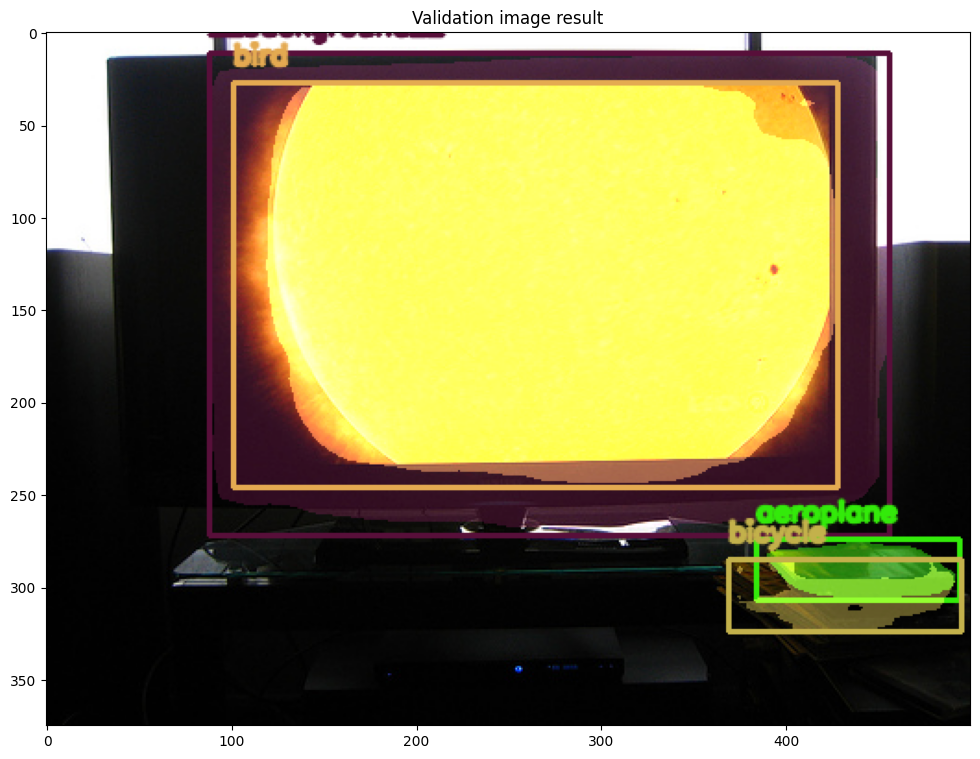

In [26]:
from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

In [29]:
def evaluate(model, data_loader, device):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = "Test:"

    with torch.no_grad():
        for images, targets in metric_logger.log_every(data_loader, 100, header):
            images = list(img.to(device) for img in images)

            model(images)

results = evaluate(model, val_loader, 'cuda:0')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test:  [:3d/728]  eta: 0:22:18    time: 1.8392  data: 0.5721
Test:  [:3d/728]  eta: 0:15:51    time: 1.4689  data: 0.0134
Test:  [:3d/728]  eta: 0:13:07    time: 1.4284  data: 0.0122
Test:  [:3d/728]  eta: 0:10:34    time: 1.5543  data: 0.0142
Test:  [:3d/728]  eta: 0:08:06    time: 1.5099  data: 0.0121
Test:  [:3d/728]  eta: 0:05:36    time: 1.4645  data: 0.0143
Test:  [:3d/728]  eta: 0:03:08    time: 1.4125  data: 0.0128
Test:  [:3d/728]  eta: 0:00:41    time: 1.4669  data: 0.0138
Test: Total time: 0:17:49
